## Notes and ideas :
- look for the frequency of publication of articles.
#### Features to be included in the template:
- Images with more weighting than the body of the article ( they may contain more information and impact on the reader).
- Measure the degree of objectivity or subjectivity (using the Vader metric) of bbc news writers by calculating the average distance of a bbc article from neutralitypoint (this could be done by applying the prediction model on more various categories -hence more data injected) , input this into your main model.
- Count the number of authors and see if studying each author separately is efficient, knowing that no much writters write in the climate rubrique.
- A picture (if subjective) is worth a thousand words", but if it is not significant, i.e. objective, it has no impact, no matter how much we consider it, the final result will not be affected. so we multiply the picture text (not a thousand times ofc hhh) to ponder with the rest of the article content.

## Insight :
- Transfer learning is already applied, make sure in the insight that you offer a path to relearn the Vader program to articles similar to bbc news.  

In [101]:
import os
import csv
import json
import nltk
import spacy 
import shutil
import gcloud
import requests
import requests
import numpy as np
import pandas as pd
import urllib.request
from PIL import Image
from spacy import displacy
from tqdm.notebook import *
from itertools import groupby
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from newsapi import NewsApiClient
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm
nltk.download('punkt')

# I- Fetching data :

Used to fetch news data using an original scrapper, including published images, so they be injected into the model as additional features  

In [15]:
def scrap_one_article(url, _, nbr_articles):
    try:
        dirName = 'images'
        os.mkdir(dirName)
    except:
        pass
    url_clean = url
    if url[6:19] == url[26:39]:
        url_clean = url[19:]
        print(url_clean)
    response = requests.get(url_clean)
    soup = BeautifulSoup(response.text, 'lxml')
    csv_file = open('bbc_news.csv', 'a')
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['id', 'url', 'author', 'article_content'])
    Content_list = soup.find_all(class_ = 'eq5iqo00')
    article_content = build_text(Content_list)
    print('url: ',url_clean)
    print('fetched the name of author :')
    print("fetched the article's content : ",article_content[:100],f' +[{len(article_content)-100}] chars ',)    
    img_count = download_images(soup,_,nbr_articles)
    article_dic= {'id': _ ,'url': url_clean,'author':None,'article_content':article_content,'Image count': img_count}
    return article_dic

In [22]:
def build_text(list_):
    list_.pop()
    return '\n'.join([x.text for x in list_])
def dl_img(url, file_path, file_name):
    full_path = file_path + file_name + '.jpg'
    urllib.request.urlretrieve(url, full_path)
    return full_path
def download_images(soup_result,article_index,nbr_articles):
    nbr_img = 0
    try:
        os.mkdir(f'images/Article{article_index}')
    except:
        pass
    img_results = [res['src'] for res in soup_result.find_all('img')][-12:]
    print(len(img_results))
    for _ in tqdm (range(1,len(img_results))):
        image_link = img_results[_]
        image_link_loc = f'images/Article{article_index}/'
        file_name = f'img{_}'
        try:
            image_link_local = dl_img(image_link,image_link_loc, file_name)
            i += 1
            nbr_img+=1
        except:
            pass
        return nbr_img
def get_links_list(soup):
        results = soup.find_all('a',class_ = 'gs-c-promo-heading')
        links_list = ['http://www.bbc.com/'+res['href'] if (res['href'][6:19] != res['href'][26:39]) else res['href'] for res in results]
        return links_list


In [27]:
def scrap_bbc_articles(category_url):
    try:    
        shutil.rmtree('images') 
    except:
        pass
    url = category_url
    response = requests.get(url)
    print('Request status (200 means a succesful request): ',response.status_code)
    soup = BeautifulSoup(response.text, 'lxml')
    links = get_links_list(soup)
    print('fetching begun ...')
    try: 
        csv_file = open('bbc_news.csv', 'a')
        print('Csv file created under the name bbc_news.csv')
    except: 
        pass
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['id', 'link', 'Author', 'Article content', 'publishing date' ])
    print('Fetching data from ',len(links) - 5 ,' bbc news articles')
    results = []
    for _ in range(1,len(links)-5):  # Covers all the articles len(links)+1
        print('------------------------------------')
        try: 
            A = scrap_one_article(links[_], _, len(links))
            results.append(A)
        except:
            pass
    csv_file.close()
    return results


In [28]:
climate_url = 'https://www.bbc.com/news/science-environment-56837908'
data = scrap_bbc_articles(climate_url)
def fetch_clean_data(data_list): 
    article_results = [] 
    for i in range(len(data_list)):
        try:
            article_dict = {}
            article_dict['id'] = data_list[i]['id']
            article_dict['author'] = data_list[i]['author']
            article_dict['url'] = data_list[i]['url']
            article_dict['article_content'] = data_list[i]['article_content'].strip("\n").strip("\t")
            article_results.append(article_dict)
        except IndexError:
            pass
    return article_results

Request status (200 means a succesful request):  200
fetching begun ...
Csv file created under the name bbc_news.csv
Fetching data from  38  bbc news articles
------------------------------------
url:  http://www.bbc.com//news/world-australia-59390798
fetched the name of author :
fetched the article's content :  When eight teenagers and an elderly nun in Australia teamed up for a climate case, they won, in a hi  +[7903] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59649066
fetched the name of author :
fetched the article's content :  The highest temperature ever recorded in the Arctic, 38C (100F), has been officially confirmed, soun  +[2977] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59644494
fetched the name of author :
fetched the article's content :  Scientists are warning of dramatic changes at one of the biggest glaciers in Antarctica, potentially  +[4397] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-58913875
fetched the name of author :
fetched the article's content :  Making your home more energy efficient can be costly and may not be possible if you're renting, or y  +[4569] chars 
12



------------------------------------
url:  http://www.bbc.com//news/59387191
fetched the name of author :
fetched the article's content :  Indonesia pledged at the recent COP26 climate summit that its greenhouse gas emissions would peak by  +[5474] chars 
12



------------------------------------
url:  http://www.bbc.com//news/world-asia-59525480
fetched the name of author :
fetched the article's content :  It's a glorious autumn afternoon and I'm standing on a hillside looking out over Tokyo Bay. Beside m  +[6721] chars 
12



------------------------------------
url:  http://www.bbc.com//news/uk-scotland-north-east-orkney-shetland-59517776
fetched the name of author :
fetched the article's content :  Business leaders have warned that thousands of oil and gas jobs could be at risk in the UK after She  +[6016] chars 
12



------------------------------------
url:  http://www.bbc.com//news/world-australia-59390798
fetched the name of author :
fetched the article's content :  When eight teenagers and an elderly nun in Australia teamed up for a climate case, they won, in a hi  +[7903] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59649066
fetched the name of author :
fetched the article's content :  The highest temperature ever recorded in the Arctic, 38C (100F), has been officially confirmed, soun  +[2977] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59644494
fetched the name of author :
fetched the article's content :  Scientists are warning of dramatic changes at one of the biggest glaciers in Antarctica, potentially  +[4397] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-58913875
fetched the name of author :
fetched the article's content :  Making your home more energy efficient can be costly and may not be possible if you're renting, or y  +[4569] chars 
12



------------------------------------
url:  http://www.bbc.com//news/59387191
fetched the name of author :
fetched the article's content :  Indonesia pledged at the recent COP26 climate summit that its greenhouse gas emissions would peak by  +[5474] chars 
12



------------------------------------
url:  http://www.bbc.com//news/world-asia-59525480
fetched the name of author :
fetched the article's content :  It's a glorious autumn afternoon and I'm standing on a hillside looking out over Tokyo Bay. Beside m  +[6721] chars 
12



------------------------------------
url:  http://www.bbc.com//news/uk-scotland-north-east-orkney-shetland-59517776
fetched the name of author :
fetched the article's content :  Business leaders have warned that thousands of oil and gas jobs could be at risk in the UK after She  +[6016] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59649066
fetched the name of author :
fetched the article's content :  The highest temperature ever recorded in the Arctic, 38C (100F), has been officially confirmed, soun  +[2977] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59644494
fetched the name of author :
fetched the article's content :  Scientists are warning of dramatic changes at one of the biggest glaciers in Antarctica, potentially  +[4397] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-58913875
fetched the name of author :
fetched the article's content :  Making your home more energy efficient can be costly and may not be possible if you're renting, or y  +[4569] chars 
12



------------------------------------
url:  http://www.bbc.com//news/59387191
fetched the name of author :
fetched the article's content :  Indonesia pledged at the recent COP26 climate summit that its greenhouse gas emissions would peak by  +[5474] chars 
12



------------------------------------
url:  http://www.bbc.com//news/world-asia-59525480
fetched the name of author :
fetched the article's content :  It's a glorious autumn afternoon and I'm standing on a hillside looking out over Tokyo Bay. Beside m  +[6721] chars 
12



------------------------------------
url:  http://www.bbc.com//news/uk-scotland-north-east-orkney-shetland-59517776
fetched the name of author :
fetched the article's content :  Business leaders have warned that thousands of oil and gas jobs could be at risk in the UK after She  +[6016] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-56901261
fetched the name of author :
fetched the article's content :  A new global agreement - the Glasgow Climate Pact - was reached at the COP26 summit.
It aims to redu  +[4388] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59212185
fetched the name of author :
fetched the article's content :  As the COP26 climate summit enters its second week, negotiations in Glasgow have hit a critical phas  +[5830] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59036722
fetched the name of author :
fetched the article's content :  It's the end of week one at the COP26 climate conference in Glasgow, and world leaders have already   +[12545] chars 
12



------------------------------------
url:  http://www.bbc.com//news/59136545
fetched the name of author :
fetched the article's content :  World leaders have pledged to end and reverse deforestation by 2030.
But in Brazil's Amazon rainfore  +[4398] chars 
12



------------------------------------
url:  http://www.bbc.com//news/59135899
fetched the name of author :
fetched the article's content :  There has been criticism of the number of world leaders and other delegates who have travelled to th  +[4785] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-24021772
fetched the name of author :
fetched the article's content :  World temperatures are rising because of human activity, and climate change now threatens every aspe  +[5415] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-58954530
fetched the name of author :
fetched the article's content :  Scientists and politicians say we are facing a planetary crisis because of climate change. 
But what  +[4650] chars 
12



------------------------------------
------------------------------------
url:  http://www.bbc.com//news/science-environment-46459714
fetched the name of author :
fetched the article's content :  Avoiding meat and dairy products is one of the biggest ways to reduce your environmental impact, acc  +[7141] chars 
------------------------------------
url:  http://www.bbc.com//news/science-environment-58874518
fetched the name of author :
fetched the article's content :  Countries have set out plans to cut greenhouse gas emissions, at the COP26 climate change summit in   +[4357] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59241053
fetched the name of author :
fetched the article's content :  Re-flooding coastal wetlands could provide an opportunity to "work with nature" and use sea level ri  +[2036] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-58399809
fetched the name of author :
fetched the article's content :  In our monthly feature, Then and Now, we reveal some of the ways that planet Earth has been changing  +[4404] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-57149747
fetched the name of author :
fetched the article's content :  In our monthly feature, Then and Now, we reveal some of the ways that planet Earth has been changing  +[3032] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-56225862
fetched the name of author :
fetched the article's content :  In our monthly feature, Then and Now, we reveal some of the ways that planet Earth has been changing  +[5733] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-56902340
fetched the name of author :
fetched the article's content :  In our monthly feature, Then and Now, we reveal some of the ways that planet Earth has been changing  +[3649] chars 
12



------------------------------------
https://www.bbc.com/future/article/20211214-doughnuts-the-fried-treat-that-conquered-the-modern-world
------------------------------------
https://www.bbc.com/worklife/article/20211209-the-6-biggest-lessons-about-work-from-2021


In [102]:
Data = pd.DataFrame.from_dict(fetch_clean_data(data))
pd.set_option('max_colwidth', 500)
Data.head()

id author                                                    url  \
0   1   None      http://www.bbc.com//news/world-australia-59390798   
1   2   None  http://www.bbc.com//news/science-environment-59649066   
2   3   None  http://www.bbc.com//news/science-environment-59644494   
3   4   None  http://www.bbc.com//news/science-environment-58913875   
4   5   None                      http://www.bbc.com//news/59387191   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       article_content  
0  When eight teenagers and an elderly nun in Australia teamed up for a climate case, they won, in a historic judgement. Their case has now been appealed by the country's government. If the final verdict swings in their favour, it will have ramifications not just for Australian law but for climate cases world-wide. \nIn May this year, Anjali Sharma was sitting in her economics class at school in Melbourne when the court in Sydney live-streamed the results of a climate case she had found herself...  
1  The highest temperature ever recorded in the Arctic, 38C (100F), has been officially confirmed, sounding "alarm bells" over Earth's changing climate.\nThe World Meteorological Organization (WMO) on Tuesday verified the record, reported in the Siberian town of Verkhoyansk on 20 June last year. \nThe temperature was 18C higher than the area's average daily maximum for June.\nThe WMO, a UN agency, said the extreme heat was "more befitting the Mediterranean than the Arctic".\nIt is the first tim...  
2  Scientists are warning of dramatic changes at one of the biggest glaciers in Antarctica, potentially within the next five to 10 years.\nThey say a floating section at the front of Thwaites Glacier that until now has been relatively stable could "shatter like a car windscreen". \nUS and UK researchers are currently engaged in an intense study programme at Thwaites because of its melt rate. \nAlready it is dumping 50 billion tonnes of ice into the ocean each year.\nThis is having limited impac...  
3  Making your home more energy efficient can be costly and may not be possible if you're renting, or you don't have thousands of pounds stashed away to buy new heat pumps and double glazing.\nBut there are some cheap solutions to try to save money. We've looked at where you are likely to be losing the most energy in your home and come up with some simple solutions to help save money on your bills and keep warm this winter.\nWarm air wants to leave your home and will find any nook and cranny to...  
4  Indonesia pledged at the recent COP26 climate summit that its greenhouse gas emissions would peak by 2030 and then start to fall. \nIt's also said that it will end deforestation by that same date.\nBut to reduce emissions from its transport sector, it's relying on using more biofuels - production of which can lead to the loss of forested land.\nSo how can it both curb its emissions using biofuels and end deforestation by 2030?\nIndonesia is now the third largest producer of biofuels in the w...

In [103]:
Data.to_csv('exported_bbc_data.csv')
Data.to_excel('exported_bbc_data.xlsx')

In [104]:
Data.count()

id                 33
author              0
url                33
article_content    33
dtype: int64

<h1> II- Data preprocessing :</h1>

### Introduction
Feature engineering is an important process in the pipeline of any machine learning project.
It involves applying a series of transformations to the data, including
data, including eliminating bad records, encoding variables, scaling variables and finally eliminating
scaling of variables and finally the elimination of variables with a high correlation.
The motivation behind this process is to feed the algorithms with digested data
and to improve their performance by reducing the learning time.
In this project, different data processing techniques were applied to implement the machine learning models.
the machine learning models and improve their performance, which we will discuss below.
we will discuss below.
### Missing value rate and zero variance
Here we try to eliminate variables with a very high rate of missing values
or zero variance. The following variables are then removed from our final database

In [105]:
Data.columns

Index(['id', 'author', 'url', 'article_content'], dtype='object')

In [133]:
def clean(Data):
    #lower case all content
    Data['article_content'] = Data["article_content"].map(lambda x: x.lower()) 
    #removing punctuation
    punc = '!()-[]{};:"\,<>./?@#$%^&*_~'
    def strip_punc(text):
        for ele in text:
            if ele in punc:
                text = text.replace(ele, "")                                                   
        return text
    Data['article_content'] = Data["article_content"].map(lambda x: strip_punc(x)) #lower case all content
clean(Data)
Data

id author  \
0    1   None   
1    2   None   
2    3   None   
3    4   None   
4    5   None   
5    6   None   
6    7   None   
7    8   None   
8    9   None   
9   10   None   
10  11   None   
11  12   None   
12  13   None   
13  14   None   
14  15   None   
15  16   None   
16  17   None   
17  18   None   
18  19   None   
19  20   None   
20  21   None   
21  22   None   
22  23   None   
23  24   None   
24  25   None   
25  26   None   
26  27   None   
27  30   None   
28  31   None   
29  32   None   
30  33   None   
31  34   None   
32  35   None   

                                                                         url  \
0                          http://www.bbc.com//news/world-australia-59390798   
1                      http://www.bbc.com//news/science-environment-59649066   
2                      http://www.bbc.com//news/science-environment-59644494   
3                      http://www.bbc.com//news/science-environment-58913875   
4                                          http://www.bbc.com//news/59387191   
5                               http://www.bbc.com//news/world-asia-59525480   
6   http://www.bbc.com//news/uk-scotland-north-east-orkney-shetland-59517776   
7                          http://www.bbc.com//news/world-australia-59390798   
8                      http://www.bbc.com//news/science-environment-59649066   
9                      http://www.bbc.com//news/science-environment-59644494   
10                     http://www.bbc.com//news/science-environment-58913875   
11                                         http://www.bbc.com//news/59387191   
12                              http://www.bbc.com//news/world-asia-59525480   
13  http://www.bbc.com//news/uk-scotland-north-east-orkney-shetland-59517776   
14                     http://www.bbc.com//news/science-environment-59649066   
15                     http://www.bbc.com//news/science-environment-59644494   
16                     http://www.bbc.com//news/science-environment-58913875   
17                                         http://www.bbc.com//news/59387191   
18                              http://www.bbc.com//news/world-asia-59525480   
19  http://www.bbc.com//news/uk-scotland-north-east-orkney-shetland-59517776   
20                     http://www.bbc.com//news/science-environment-56901261   
21                     http://www.bbc.com//news/science-environment-59212185   
22                     http://www.bbc.com//news/science-environment-59036722   
23                                         http://www.bbc.com//news/59136545   
24                                         http://www.bbc.com//news/59135899   
25                     http://www.bbc.com//news/science-environment-24021772   
26                     http://www.bbc.com//news/science-environment-58954530   
27                     http://www.bbc.com//news/science-environment-58874518   
28                     http://www.bbc.com//news/science-environment-59241053   
29                     http://www.bbc.com//news/science-environment-58399809   
30                     http://www.bbc.com//news/science-environment-57149747   
31                     http://www.bbc.com//news/science-environment-56225862   
32                     http://www.bbc.com//news/science-environment-56902340   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        article_content  
0   when eight teenagers and an elderly nun in australia teamed up for a climate case they won in a historic judgement their case has now been appealed by the country's government if the final verdi

### NER : Named entities recognition :
As it is part of the task, we are asked to display sentiment analysis for each NER.
the aim of this sub-section is to try differnet Nlp models to get NERs from text.
#### 1- Standford Ner :

Installation and Configuration: https://medium.com/manash-en-blog/configuring-stanford-parser-and-stanford-ner-tagger-with-nltk-in-python-on-windows-f685483c374a

Stanford link: https://nlp.stanford.edu/software/CRF-NER.html

In [117]:
str_ =str(Data.iloc[4]['article_content']) # sample article

In [118]:
model = "C:/Users/oussama/Desktop/nltk_standford/stanford-ner-2020-11-17/classifiers/english.all.3class.distsim.crf.ser.gz"
jar = "C:/Users/oussama/Desktop/nltk_standford/stanford-ner-2020-11-17/stanford-ner.jar"
st = StanfordNERTagger(model, jar,encoding='utf-8')
java_path = "C:/Program Files/Java/jdk-17.0.1/bin/java.exe" 
os.environ["JAVAHOME"] = java_path

In [119]:
tokenized_text = nltk.word_tokenize(str_)
classified_text = st.tag(tokenized_text)
netagged_words = classified_text
entities = []
labels = []
for tag, chunk in groupby(classified_text, lambda x:x[1]):
    if tag != "O":
        entities.append(' '.join(w for w, t in chunk))
        labels.append(tag)
entities_all = list(zip(entities, labels))
entities_unique = list(set(zip(entities, labels))) #unique entities   
data_entities_1 = pd.DataFrame(entities_unique)
data_entities_1.columns = ["Entities", "Labels"]
data_entities_1


Entities        Labels
0                     Germany      LOCATION
1                         BBC  ORGANIZATION
2                   Indonesia      LOCATION
3         Global Forest Watch  ORGANIZATION
4                          EU  ORGANIZATION
5   Carbon Disclosure Project  ORGANIZATION
6           Filda Yusgiantoro        PERSON
7                          US      LOCATION
8                Nurika Manan        PERSON
9                    Thailand      LOCATION
10                     Brazil      LOCATION
11     Febry Calvin Tetelepta        PERSON
12                Joko Widodo        PERSON
13     Astudestra Ajengrastri        PERSON

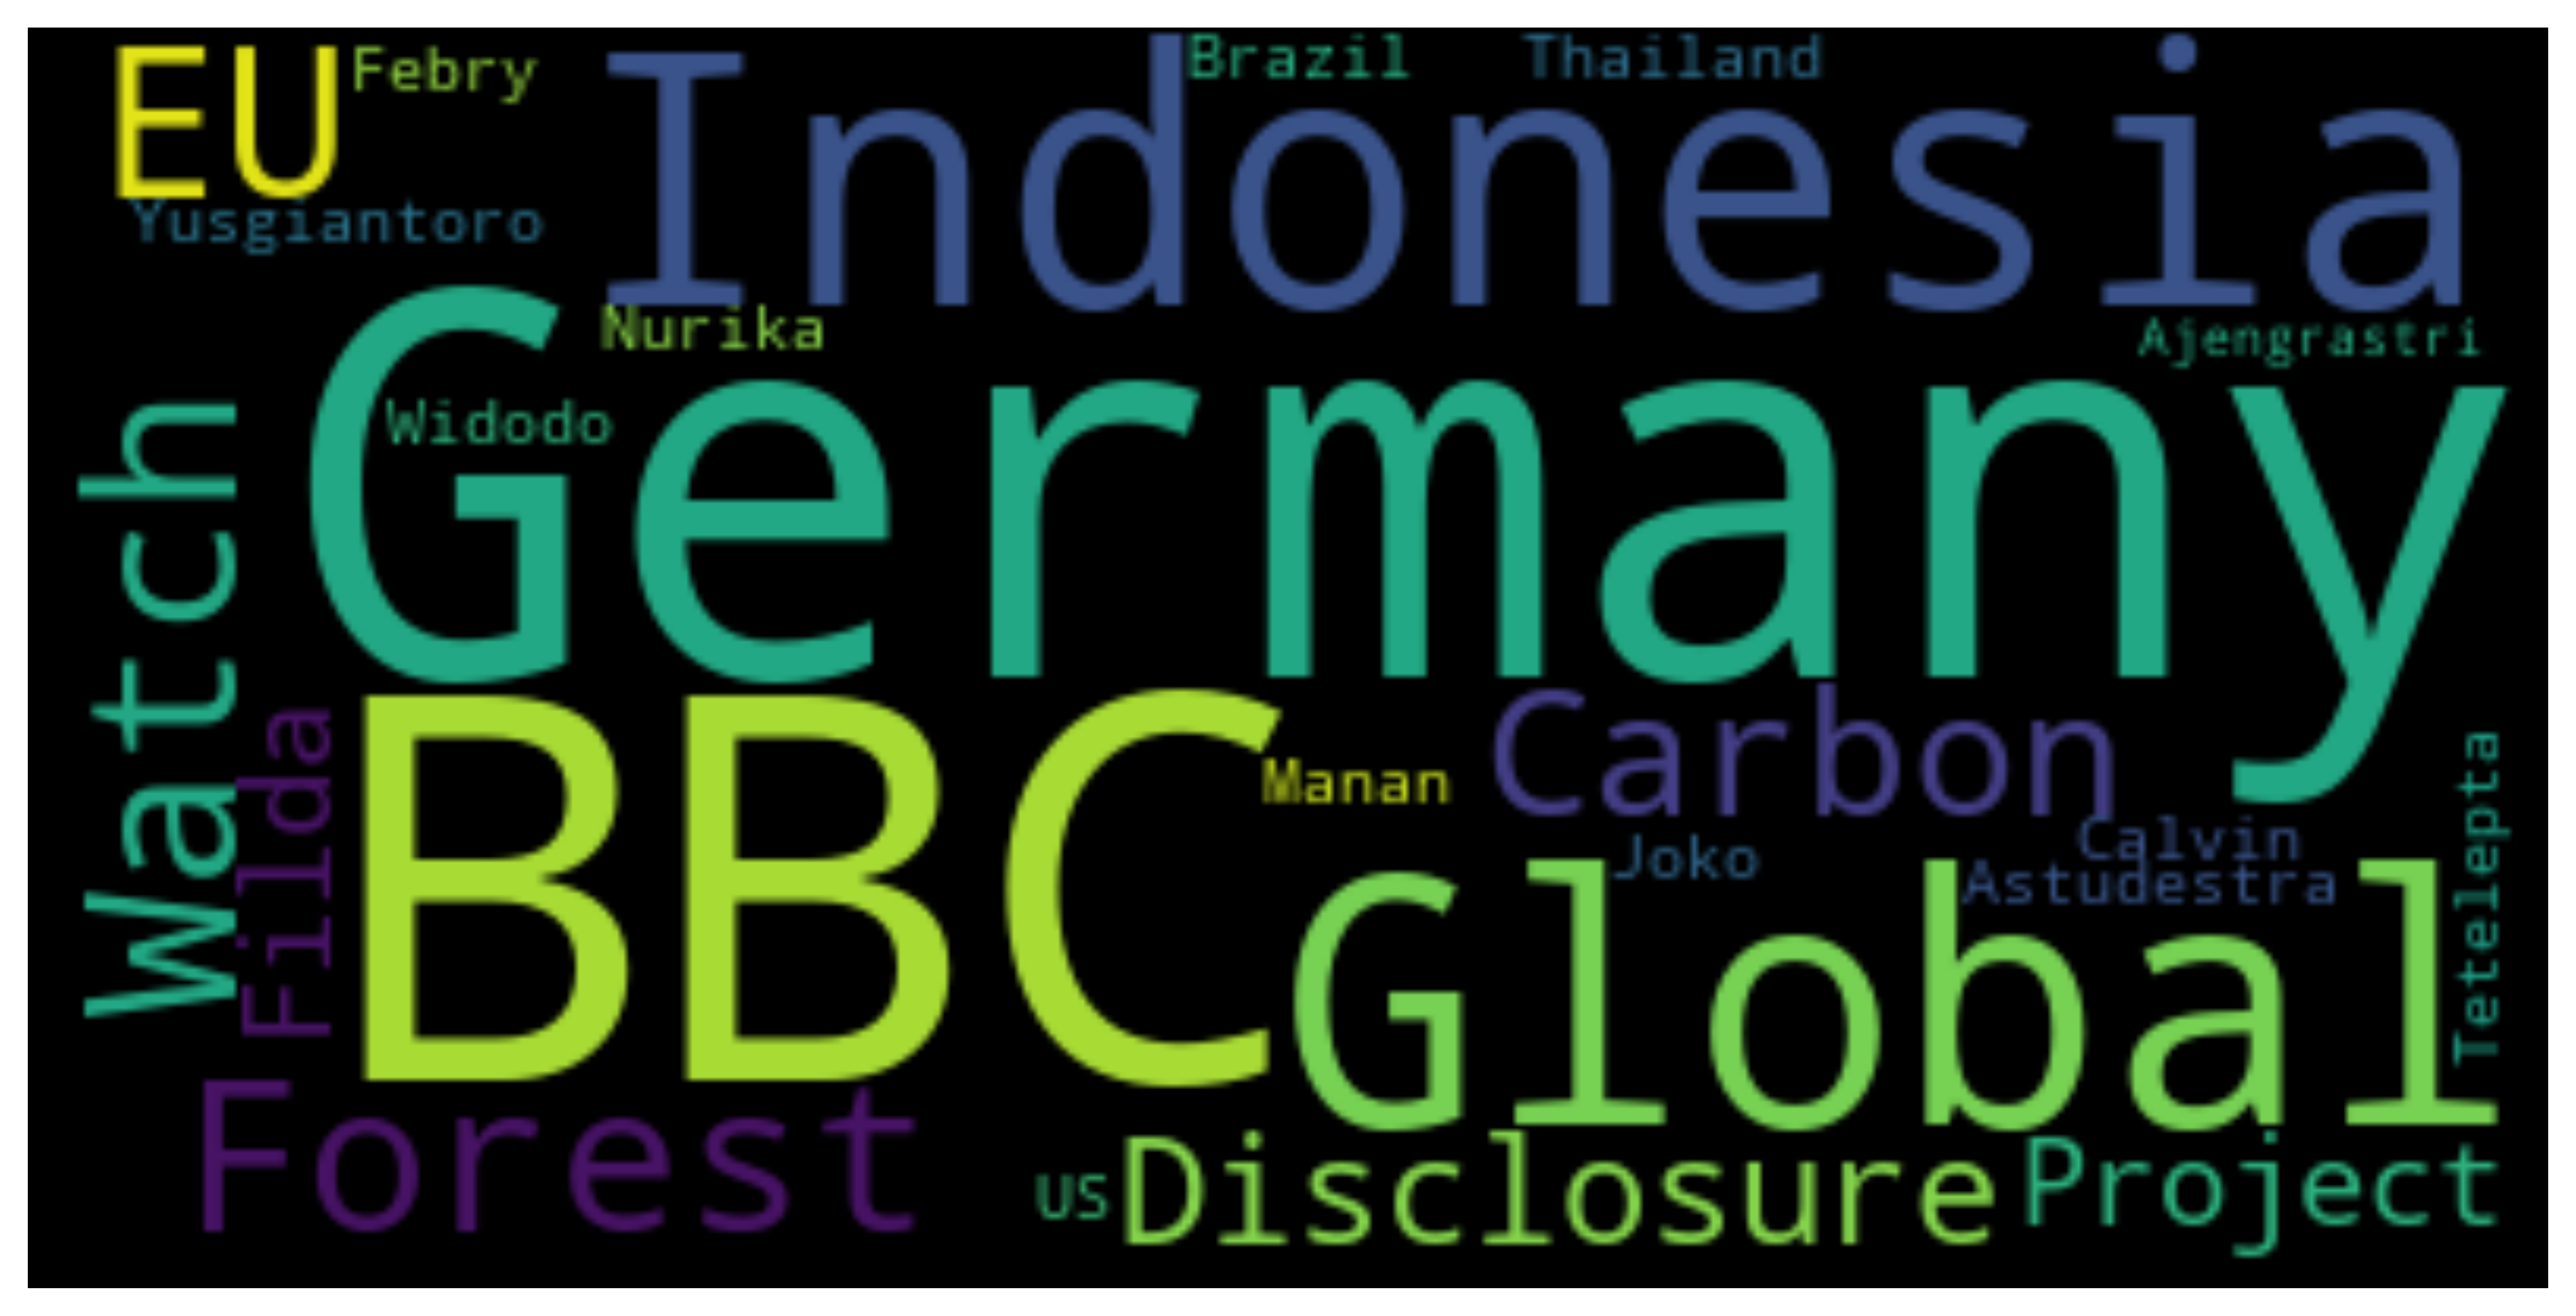

In [120]:
#illustration of NER words, might give a general idea
text = ' '.join(data_entities_1['Entities'].to_list()) 
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
from matplotlib.pyplot import figure
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 6)
fig.set_dpi(1000)
plt.show()

#### 2 - Scapy :
`pip install cloudword`

Link: https://spacy.io/

In [121]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(str_)
entities = []
labels = []
position_start = []
position_end = []
for ent in doc.ents:
    entities.append(ent)
    labels.append(ent.label_)
    position_start.append(ent.start_char)
    position_end.append(ent.end_char)
data_entities_2 = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})
data_entities_2

Entities   Labels  Position_Start  Position_End
0                 (Indonesia)      GPE               0             9
1                      (2030)     DATE             101           105
2                      (2030)     DATE             422           426
3                 (Indonesia)      GPE             428           437
4                     (third)  ORDINAL             449           454
..                        ...      ...             ...           ...
56                (Indonesia)      GPE            5191          5200
57  (Astudestra, Ajengrastri)   PERSON            5398          5420
58            (Nurika, Manan)   PERSON            5425          5437
59                      (BBC)      ORG            5443          5446
60               (12, months)     DATE            5470          5479

[61 rows x 4 columns]